# Projetos de ciência de dados com Python

## Capítulo 6 - Imputação de dados faltantes, análise financeira e distribuição para o cliente

### Exercícios

- Exercício 22: Limpando o dataset

- Exercício 23: Imputação de `PAY_1` pela moda e aleatória

- Exercício 24: construindo um modelo de classificação multiclasse para a imputação

- Exercício 25: Caracterizando custos e economias

- Atividade 6: Derivando insights financeiros

---

### Exercício 22: Limpando o dataset

Neste exercício, limparemos nosso dataset para resolver o problema das entradas de dados faltantes. Usaremos a mesma abordagem do *Capítulo 1, Exploração e limpeza de dados*. Execute as etapas a seguir para fazer o exercício:

##### 1. Carregue o dataset original que usamos no começo de nossa exploração antes de a limpeza ocorrer

In [1]:
import pandas as pd

df_orig = pd.read_excel('default_of_credit_card_clients__courseware_version_1_21_19.xls')

Temos de repetir todas as etapas de limpeza de dados com exceção da remoção das amostras em que a característica `PAY_1` tinha valores faltantes. Como primeira etapa, identifique e remova qualquer amostra em que os valores de todas as características sem iguais a 0. Determinamos que essa seria uma maneira eficaz de remover IDs de conta duplicados do dataset.

##### 2. Crie um array booleano que indique onde as entradas do DataFrame são iguais a 0:

In [2]:
df_zero_mask = df_orig == 0

##### 3. Reduza esse array booleano bidimensional para uma única dimensão indicando que linhas têm 0's em todas as colunas, começando pela segunda coluna. Esse array informará que linhas têm valor 0 para todas as características e precisam ser removidas:

In [3]:
feature_zero_mask = df_zero_mask.iloc[:,1:].all(axis=1)

##### 4. Verifique se o número de linhas em que todos os valores são 0 para as características é igual ao do *Capítulo 1, Exploração e limpeza de dados*:

In [4]:
sum(feature_zero_mask)

315

O resultado é o mesmo do *Capítulo 1, Exploração e limpeza de dados*.

##### 5. Use esta máscara para selecionar as outras linhas, isto é, as que não têm valores 0 para todas as características, e verifique a dimensão do DataFrame resultante:

In [5]:
df_clean = df_orig.loc[~feature_zero_mask,:].copy()
df_clean.shape

(29685, 25)

Além de remover dados claramente inválidos (amostras com todas as características iguais a 0), o objetivo desse procedimento era eliminar IDs de conta duplicados.

##### 6. Verifique se o número de IDs de conta exclusivos é igual ao número de linhas do DataFrame limpo:

In [6]:
df_clean['ID'].nunique()

29685

O resultado é igual ao número de linhas do DataFrame, indicando que os dados foram limpos com a remoção de IDs de conta duplicados.

##### 7. Substitua os valores não documentados das características `EDUCATION` e `MARRIAGE` pelo valor documentado para "desconhecido". Simplesmente repita o código do *Capítulo 1, Exploração e limpeza de dados* que faz isso:

In [7]:
df_clean['EDUCATION'].replace([0, 5, 6], 4, inplace=True)
df_clean['MARRIAGE'].replace(0, 3, inplace=True)

Agora os dados estão em um estado limpo. A pergunta que devemos fazer então é como incluir as amostras com valores faltantes para `PAY_1` com o resto dos dados.

Reservamos um conjunto de teste desconhecido de todas as atividades de modelagem que executamos até aqui. As amostras desse dataset só devem ser usadas depois que selecionarmos nosso modelo final e quisermos ver se o desempenho fora da amostra que estimamos com a validação cruzada se reflete nos novos dados. Logo, seria melhor continuar mantendo essas amostras isoladas do trabalho de modelagem, inclusive da seleção de uma estratégia de imputação. Para fazê-lo, criaremos um subconjunto das amostras de nosso dataset limpo que têm valores faltantes para `PAY_1` e as adicionaremos aos conjuntos de treinamento e teste posteriormente para que a proporção de dados de treinamento e teste permaneça igual.

##### 8. Recapitule quais são os valores de `PAY_1`:

In [8]:
df_clean['PAY_1'].value_counts()

PAY_1
0                13087
-1                5047
1                 3261
Not available     3021
-2                2476
2                 2378
3                  292
4                   63
5                   23
8                   17
6                   11
7                    9
Name: count, dtype: int64

Antes de isolar as amostras em que o valor de `PAY_1` está faltando, observe que a moda de valores não faltantes de `PAY_1`, ou seja, o valor predominante, é 0. Usaremos esse fato posteriormente quando testarmos diferentes estratégias de imputação.

Os valores faltantes em `PAY_1` são indicados pela string *"Not available"*.

##### 9. Crie uma máscara booleana para identificas as linhas que têm esse valor:

In [9]:
missing_pay_1_mask = df_clean['PAY_1'] == 'Not available'

##### 10. Confirme se o número de amostras com dados faltantes é 3.021 como observado no *Capítulo 1, Exploração e limpeza de dados*:

In [10]:
sum(missing_pay_1_mask)

3021

##### 11. Faça uma cópia dessas linhas em um novo DataFrame que adicionaremos aos dados que usamos na modelagem

In [11]:
df_missing_pay_1 = df_clean.loc[missing_pay_1_mask,:].copy()

##### 12. Carregue os dados limpos com os quais trabalhamos nos capítulos 2 a 5. Já removemos as 3.021 amostras com valor faltante para `PAY_1` desses dados, logo, é um conjunto de amostras totalmente diferente do que armazenamos em *df_missing_pay_1*:

In [12]:
df = pd.read_csv('chapter_1_cleaned_data.csv')

##### 13. Crie uma lista com os nomes das colunas desse DataFrame e remova as strings que não fizerem parte do conjunto de características e variável de resposta. Aqui estão os nomes das colunas.

In [13]:
df.columns

Index(['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_1',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'default payment next month', 'EDUCATION_CAT', 'graduate school',
       'high school', 'others', 'university'],
      dtype='object')

##### 14. Atribua os nomes das colunas a uma lista:

In [14]:
features_response = df.columns.tolist()

##### 15. Crie uma lista de nomes de coluna que não sejam das características ou da reposta para podermos removê-los:

In [15]:
item_to_remove = ['ID','SEX', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'EDUCATION_CAT', 'graduate school', 'high school', 'others', 'university']

##### 16. Use uma list comprehension para remover os nomes de colunas indesejados e exibir o resultado:

In [16]:
features_response = [item for item in features_response if item not in item_to_remove]
features_response

['LIMIT_BAL',
 'EDUCATION',
 'MARRIAGE',
 'AGE',
 'PAY_1',
 'BILL_AMT1',
 'BILL_AMT2',
 'BILL_AMT3',
 'BILL_AMT4',
 'BILL_AMT5',
 'BILL_AMT6',
 'PAY_AMT1',
 'PAY_AMT2',
 'PAY_AMT3',
 'PAY_AMT4',
 'PAY_AMT5',
 'PAY_AMT6',
 'default payment next month']

Essa lista de nomes de coluna será útil quando estivermos selecionando dados do DataFrames, inclusive valores faltantes e não faltantes de `PAY_1`, para combiná-los e testar diferentes estratégias de imputação, o que será feito no próximo exercício.

---

### Exercício 23: Imputação de `PAY_1` pela moda e aleatória

Neste exemplo, testaremos algumas dsas estratégias de imputação mais simples disponíveis para `PAY_1` e veremos seus efeitos sobre o desempenho da validação cruzada. As primeiras etapas serão acrescentar as amostras com valores faltantes para `PAY_1` ao final do conjunto de teste com o qual estávamos trabalhando, que não tem valores faltantes para `PAY_1`. Teremos de embaralhá-las ao executar a validação cruzada para que as amostras com valores faltantes de `PAY_1` não fiquem todas no mesmo fold, o que criaria uma situação em que os dados de um dos folds seriam diferentes dos outros

Embora `PAY_1` tenha valores numéricos, é uma característica híbrida entre categórica e numérica como discutimos anteriormente. Vamos tratá-la como categórica para os fins de imputação, ja que, se quisermos calcular a média dos valores não faltantes de `PAY_1`, por exemplo, o resultado pode não ser um inteiro, e não seria interpretável dada a definição de `PAY_1`. Logo, as estratégias de imputação mais simples que temos disponíveis são a moda e a mediana. Uma estratégia um pouco mais complexa é a seleção aleatória das amostras com valores não faltantes para `PAY_1`. Vamos examiná-las aqui. Execute as etapas a seguir para fazer o exercício:

##### 1. Importe a classe *train_test_split* do módulo *sklearn* para podermos trabalhar com o mesmo conjunto de teste reservado que estávamos usando:

In [17]:
from sklearn.model_selection import train_test_split

##### 2. Crie uma divisão 80/20 de treinamento/teste usando o mesmo seed aleatório com o qual trabalhamos:

In [18]:
X_train, X_test, y_train, y_test = train_test_split(df[features_response[:-1]].values, df['default payment next month'].values, test_size=0.2, random_state=24)

##### 3. Examine as dimensões dos conjuntos de treinamento e teste:

In [19]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(21331, 17)
(5333, 17)
(21331,)
(5333,)


##### 4. Crie os valores de imputação para `PAY_1`. Primeiro confirme em que índice `PAY_1` está na lista de nomes de características e resposta:

In [20]:
features_response[4]

'PAY_1'

Precisaremos desse índice para acessar os valores não faltantes de `PAY_1` no array de características de treinamento.

##### 5. Encontre os valores de `PAY_1` que poderemos usar na imputação. Primeiro verifique qual é a mediana de `PAY_1` usando o código a seguir:

In [21]:
import numpy as np

np.median(X_train[:,4])

0.0

Podemos ver que a mediana dos valores não faltantes de `PAY_1` é 0. Você deve se lembrar de que vimos em nossa contagem de valores (*value_counts*) de `PAY_1` que a moda de valores não faltantes também é 0.

Já que a medida e a moda são iguais, só temos duas estratégias de imputação para testar neste exercício: a moda/mediana e a seleção aleatória de valores não faltantes

##### 6. Crie uma lista de valores para testar na imputação. Podemos usar um único valor numérico, 0, para representar a mediana e a moda, assim como função *random.choice* do *NumPy* para extrair uma amostra aleatória de valores não faltantes de `PAY_1`:

In [22]:
np.random.seed(1)
fill_values = [0, np.random.choice(X_train[:,4], size=(3021,), replace=True)]

Observe que, para obter a amostra aleatória, fornecemos o seed do gerador de números aleatórios a fim de obter resultados consistentes entre as execuções, indicamos o array de onde será extraída a seleção aleatória (os valores não faltantes de `PAY_1` nos dados de treinamento: *X_train[:,4]), definimos que o tamanho da amostra aleatória será igual ao da coluna de valores faltantes de `PAY_1` em *df_missing_pay_1* (3.021) e determinamos que queremos usar a amostra com substituição.

##### 7. Crie uma lista de nomes para as estratégias de imputação a fim de ajudá-lo a monitorá-las:

In [23]:
fill_strategy = ['mode', 'random']

##### 8. Examine o segundo elemento da lista *fill_values*, que é o array de seleções aleatórias de `PAY_1`:

In [24]:
fill_values[-1]

array([ 0,  0,  0, ...,  2,  0, -2])

A sída tem a aparência esperada; esses valores são inteiros no intervalo [-2, 8] e sabemos que esse é o formato de `PAY_1`. No entanto, seria melhor visualizar um resumo gráfico de todos os valores imputados para compará-los com a distribuição de `PAY_1`. No entanto, seria melhor visualizar um resumo gráfico de todos os valores imputados para compará-los com a distribuição de `PAY_1`. Isso nos permiritia confirmar se as distribuições são iguais, como se espera da imputação aleatória feita dessa forma.

##### 9. Use histogramas para examinar as distribuições da característica `PAY_1` original sem valores faltantes no conjunto de treinamento e os valores selecionados imputados aleatoriamente:

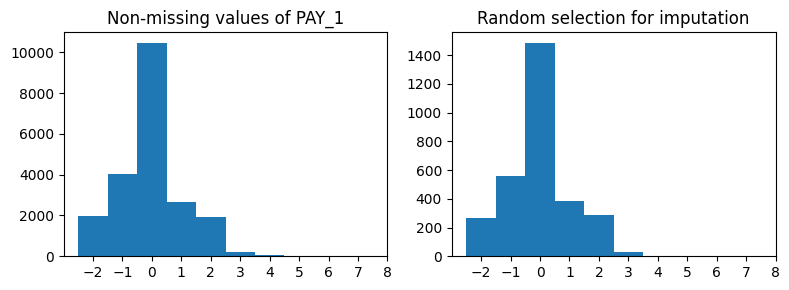

In [25]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1,2, figsize=(8,3))
bin_edges = np.arange(-2,9)
axs[0].hist(X_train[:,4], bins=bin_edges, align='left')
axs[0].set_xticks(bin_edges)
axs[0].set_title('Non-missing values of PAY_1')
axs[1].hist(fill_values[-1], bins=bin_edges, align='left')
axs[1].set_xticks(bin_edges)
axs[1].set_title('Random selection for imputation')
plt.tight_layout()

Essas duas distribuições parecem muito semelhantes. Só a escala do eixo y é que indica que há menos valores imputados do que os valores que existem no dataset original. Isso mostra que selecionamos valores para `PAY_1` que imitam fielmente a frequência relativa de diferentes valores dessa característica nos dados. Estamos prontos para definir a validação cruzada que usaremos para comparar os métodos de imputação

Não precisaremos fazer uma busca de hiperparâmetros com validação cruzada, como fizemos com a função *GridSearchCV* do scikit-lear. Já sabemos que a floresta aleatória é o modelo que usaremos e os hiperparâmetros que devemos empregar. Queremos executar a validação cruzada com um único conjunto de hiperparâmetros para ter várias estimativas da pontuação de teste fora da amostra. Para fazê-lo, podemos usar uma classe semelhante, porém mais simples, chamada *cross_validate*, junto com a classe *KFold*. Essas classes podem nos ajudar a executar a validação cruzada como fizemos com *GridSearchCV*, mas não envolvem uma busca na grade de hiperparâmetros

##### 10. Importe a classe *KFold* com este código:

In [26]:
from sklearn.model_selection import KFold

##### 11. Instancie a classe *KFold* desta forma:

In [27]:
k_folds = KFold(n_splits=4, shuffle=True, random_state=1)

Especificamos o uso de quatro folds no conjunto de treinamento, como fizemos anteriormente ao executar a validação cruzada. Também estamos deifnindo que queremos embaralhar os dados antes de dividi-los nos folds. Isso é importante porque acrescentaremos as amostras com valores imputados ao fim dos arrays de treinamento de características e resposta. No entanto, quando executarmos a validação cruzada, queremos que essas amostras sejam "misturadas" em todos os quatro folds para que cada fold tenha alguns valores imputados. Também definimos o seed aleatório de repetição.

##### 12. Importe a classe *cross_validate*:

In [28]:
from sklearn.model_selection import cross_validate

##### 13. importe a classe do classificador de floresta aleatória:

In [29]:
from sklearn.ensemble import RandomForestClassifier

##### 14. Instancie a classe de floresta aleatória, usando os hiperparâmetros que determinamos que são os melhores para os dados do estudo de caso: 200 árvores com profundidade máxima iguarl a 9:

In [30]:
rf = RandomForestClassifier(n_estimators=200, criterion='gini', max_depth=9, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='sqrt', max_leaf_nodes=None, min_impurity_decrease=0.0, bootstrap=True, oob_score=False, n_jobs=None, random_state=4, verbose=1, warm_start=False, class_weight=None)

Embora estejamos trabalhando com dados um pouco diferentes, devido aos valores imputados, assumiremos que os hiperparâmetros que determinamos para a floresta aleatória continuam sendo os melhores. Agora passaremos para a validação cruzada. É uma célula de código longa, pontanto, a dividiremos em várias etapas.

##### Etapas 15 a 19

In [31]:
# 15. Abra um loop for. Esse loop operará com as diferentes estratégias de imputação que temos, que são duas: 
for counter in range(len(fill_values)):
        
    # 16. Dentro do loop for, a primeira etapa é criar uma cópia do DataFrame de amostras com os valores faltantes de PAY_1 e, em seguida, preencher esses valores com a estratégia de imputação que estivermos considerando:
    ## Copia o dataframe de valores faltantes de PAY_1 e atribui os valores imputados
    df_fill_pay_1_filled = df_missing_pay_1.copy()
    df_fill_pay_1_filled['PAY_1'] = fill_values[counter]

    # 17. Divida os dados imputados nos conjuntos de treinamento e teste. Aqui, só usaremos a parte de treinamento na validação cruzada. Essa operação funciona da mesma forma de quando dividimos os dados limpos com os valores faltantes removidos
    ## Divide os dados imputados em treinamento e teste, usando a mesma divisão 80/20 que empregamos com os valores não faltantes de PAY_1
    X_fill_pay_1_train, X_fill_pay_1_test, y_fill_pay_1_train, y_fill_pay_1_test = train_test_split(df_fill_pay_1_filled[features_response[:-1]].values, df_fill_pay_1_filled['default payment next month'].values, test_size=0.2, random_state=24)

    # 18. Agora queremos combinar os dados imputados com os dados não faltantes de PAY_1 com os quais trabalhamos. Vamos concatená-los:
    ## Concatena os dados imputados  com o array de dados não faltantes
    X_train_all = np.concatenate((X_train, X_fill_pay_1_train), axis=0)
    y_train_all = np.concatenate((y_train, y_fill_pay_1_train), axis=0)

    # 19. Para concluir, juntaremos tudo. Usaremos esses dados com o procedimento cross_validation, assim como com o divisor KFolds e um modelo de floresta aleatória. Exiba a pontuação média do teste, com o desvio padrão, para cada método.
    ## Usa o divisor KFolds e o modelo de floresta aleatória para obter a pontuação da validação cruzada de 4 folds para os dois métodos de imputação
    imputation_compare_cv = cross_validate(rf, X_train_all, y_train_all, scoring='roc_auc', cv=k_folds, n_jobs=-1, verbose=1, return_train_score=True, return_estimator=True, error_score='raise')

    test_score = imputation_compare_cv['test_score']
    print(fill_strategy[counter] + ' imputation: ' + 'mean testing score ' + str(np.mean(test_score)) + ', std ' + str(np.std(test_score)))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    2.3s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    2.7s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    2.4s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    2.6s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    8.5s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    8.4s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    8.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Do

mode imputation: mean testing score 0.772866246168149, std 0.0031479941297533737


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.9s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    2.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    2.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    2.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    7.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    7.3s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    7.4s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    7.6s
[Parallel(n_jobs=1)]: Do

random imputation: mean testing score 0.7692540439833129, std 0.003660875187678248


[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    8.2s finished


Essa é a etapa em que o ajuste do modelo e o teste de validação cruzada são conduzidos em segundo plano e ocultados da visualização pela classe *cross_validation*. Observe que fornecemos muitas informações para essa classe: o modelo que está passando pela validação cruzada (rf), os dados *X_train_all* e *y_train_all*, e o divisor *KFolds*, entre outras opções. Uma delas é *n_jobs=-1*, indicando a execução de tarefas em paralelo para que tudo ocorra mais rapidamente.

A saída exibida aqui indica que essas duas estratégias de imputação têm desempenhos semelhantes. No entanto, a estratégia de imputação mais simples, apenas preencher todos os valores faltantes de PAY_1 com o valor mais comum das amostras não faltantes, que é 0, tem melhor desempenho: a pontuação media de teste (ROC AUC) entre os quatro folds é 0.773 para a imputação moda versus 0.769 com o uso da imputação aleatória.

E quanto à pontuação média de teste obtida aqui, na qual incluímos as amostras com os dados faltantes, versus a pontuação média de teste que observamos quando usamos apenas os dados em que todos os valores das características eram conhecidos? Ela foi de 0.776. Logo, vimos uma pequena degradação na estimativa do desempenho de teste do modelo fora da amostra. Isso era esperado, já que agora estamos incluindo dados que têm problemas e incertezas. Porém, ainda esta dentro das 0.006 unidades de ROC AUC da melhor pontuação que observamos ao trabalhar com os dados não faltantes, então, não é tão baixa. Devemos estar confiantes de que encontramos uma maneira aceitável de fazer previsões para contar que têm valores faltantes para PAY_1, como o cliente solicitou. É possivel aumentar ainda mais a qualidade da previsão com dados imputados? Veremos se conseguimos fazer isso na próxima seção.

---

### Um modelo preditivo para `PAY_1`

Crie uma cópia do DataFrame limpo com os valores não faltantes de `PAY_1`

In [32]:
pay_1_df = df.copy()

Crie uma lista de nomes de colunas que serão características

In [33]:
features_for_imputation = pay_1_df.columns.tolist()

Crie um subconjunto dessa lista para resumi-la à lista de características do modelo de imputação removendo os nomes de todos os metadados, assim como `'default payment next month'`, de que não precisaremos aqui, e `'PAY_1'`, que é a variavel resposta desse problema:

In [34]:
item_to_remove = ['ID','SEX', 'PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'EDUCATION_CAT', 'graduate school', 'high school', 'others', 'university', 'default payment next month']

In [35]:
features_for_imputation = [item for item in features_for_imputation if item not in item_to_remove]
features_for_imputation

['LIMIT_BAL',
 'EDUCATION',
 'MARRIAGE',
 'AGE',
 'BILL_AMT1',
 'BILL_AMT2',
 'BILL_AMT3',
 'BILL_AMT4',
 'BILL_AMT5',
 'BILL_AMT6',
 'PAY_AMT1',
 'PAY_AMT2',
 'PAY_AMT3',
 'PAY_AMT4',
 'PAY_AMT5',
 'PAY_AMT6']

---

### Exercício 24: construindo um modelo de classificação multiclasse para a imputação

Neste exercício, construiremos um modelo multiclasse para a imputação. Ao construí-lo, assumiremos que a floresta aleatória é o melhor modelo a ser usado, em parte devido às nossas experências com esse dataset, e também porque o algoritmo de floresta aleatória do scikit-learn suporta imediatamente a classificação multiclasse. Há varias maneiras de usar a regressão logistica e outros algoritmos de classificação binária para a classificação multiclasse. No entanto, não entraremos nesses detalhes aqui.

Seguiremos as etapas habituais de criar uma divisão de treinamento/teste, executar uma busca de parâmetros com a validação cruzada usando os dados de treinamento e confirmar o desempenho do modelo no conjunto de teste. Já conhecemos a maioria delas, no entanto há a peculiaridade adicional de estarmos modelando um problema multiclasse. Selecionaremos a acurácia como métrica de desempenho do modelo, já que ela é um pouco mais fácil de usar com problemas multiclasse. Contudo, há maneiras de estender métricas baseadas em limite como a ROC AUC para configurações multiclasse.

Execute as etapas a seguir para fazer o exercício:

##### 1. Crie uma divisão de treinamento e teste nos dados do modelo de imputação:

In [36]:
X_impute_train, X_impute_test, y_impute_train, y_impute_test = train_test_split(pay_1_df[features_for_imputation].values, pay_1_df['PAY_1'].values, test_size=0.2, random_state=24)

##### 2. Selecione uma grade de hiperparâmetros para a pesquisa com a validação cruzada:

In [37]:
rf_impute_params = {'max_depth':[3, 6, 9, 12],
                    'n_estimators':[10, 50, 100, 200]}

Esses parâmetros são os mesmos usados para o modelo de não pagamento de dívidas.

##### 3. Importe e instancie a classe *GridSearchCV*:

In [38]:
from sklearn.model_selection import GridSearchCV

cv_rf_impute = GridSearchCV(rf, param_grid=rf_impute_params, scoring='accuracy', n_jobs=-1, refit=True, cv=4, verbose=2, error_score=np.nan, return_train_score=True)

Observe que estamos reutilizando a instância de modelo de floresta aleatória *rf* do modelo de contas de crédito inadimplentes. Todas as opções devem usar seus padrões exceto *n_estimators* e *max_depth*, que serão alteradas pelo processo de busca em grade.

Ao instanciar a classe *GridSearchCV*, agimos como antes, mas aqui usamos o método de acurácia como mencionado anteriormente. Também estamos permitindo o processamento paralelo com o *n_jobs=-1*.

##### 4. Execute a busca em grade com este código:

In [39]:
cv_rf_impute.fit(X_impute_train, y_impute_train)

Fitting 4 folds for each of 16 candidates, totalling 64 fits
[CV] END .......................max_depth=3, n_estimators=10; total time=   0.2s
[CV] END .......................max_depth=3, n_estimators=10; total time=   0.2s
[CV] END .......................max_depth=3, n_estimators=10; total time=   0.2s
[CV] END .......................max_depth=3, n_estimators=10; total time=   0.3s


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


[CV] END .......................max_depth=3, n_estimators=50; total time=   1.0s
[CV] END .......................max_depth=3, n_estimators=50; total time=   1.1s
[CV] END .......................max_depth=3, n_estimators=50; total time=   1.1s


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.2s


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.2s


[CV] END .......................max_depth=3, n_estimators=50; total time=   1.4s


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


[CV] END ......................max_depth=3, n_estimators=100; total time=   1.7s


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s


[CV] END ......................max_depth=3, n_estimators=100; total time=   2.0s
[CV] END ......................max_depth=3, n_estimators=100; total time=   1.9s
[CV] END ......................max_depth=3, n_estimators=100; total time=   1.6s


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    2.7s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    2.7s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    2.8s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s


[CV] END ......................max_depth=3, n_estimators=200; total time=   2.9s


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    3.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


[CV] END .......................max_depth=6, n_estimators=10; total time=   0.3s
[CV] END ......................max_depth=3, n_estimators=200; total time=   2.9s
[CV] END ......................max_depth=3, n_estimators=200; total time=   3.0s


[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s


[CV] END .......................max_depth=6, n_estimators=10; total time=   0.3s
[CV] END .......................max_depth=6, n_estimators=10; total time=   0.3s
[CV] END .......................max_depth=6, n_estimators=10; total time=   0.3s
[CV] END ......................max_depth=3, n_estimators=200; total time=   3.4s


[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.2s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.2s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


[CV] END .......................max_depth=6, n_estimators=50; total time=   1.2s
[CV] END .......................max_depth=6, n_estimators=50; total time=   1.2s
[CV] END .......................max_depth=6, n_estimators=50; total time=   1.2s


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.3s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s


[CV] END .......................max_depth=6, n_estimators=50; total time=   1.4s


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.2s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.3s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


[CV] END ......................max_depth=6, n_estimators=100; total time=   2.4s
[CV] END ......................max_depth=6, n_estimators=100; total time=   2.4s


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s


[CV] END ......................max_depth=6, n_estimators=100; total time=   2.6s


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s


[CV] END ......................max_depth=6, n_estimators=100; total time=   2.8s


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.2s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.2s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.2s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.3s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    4.7s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    4.8s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    4.6s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Do

[CV] END ......................max_depth=6, n_estimators=200; total time=   4.9s
[CV] END ......................max_depth=6, n_estimators=200; total time=   5.0s
[CV] END ......................max_depth=6, n_estimators=200; total time=   4.8s
[CV] END .......................max_depth=9, n_estimators=10; total time=   0.4s
[CV] END .......................max_depth=9, n_estimators=10; total time=   0.3s
[CV] END .......................max_depth=9, n_estimators=10; total time=   0.4s


[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    5.2s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s


[CV] END .......................max_depth=9, n_estimators=10; total time=   0.4s


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.3s


[CV] END ......................max_depth=6, n_estimators=200; total time=   5.5s


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.7s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.7s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s


[CV] END .......................max_depth=9, n_estimators=50; total time=   1.7s
[CV] END .......................max_depth=9, n_estimators=50; total time=   1.8s


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.7s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s


[CV] END .......................max_depth=9, n_estimators=50; total time=   1.8s


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.8s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s


[CV] END .......................max_depth=9, n_estimators=50; total time=   1.9s


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.7s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.7s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.6s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.8s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s


[CV] END ......................max_depth=9, n_estimators=100; total time=   3.4s


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


[CV] END ......................max_depth=9, n_estimators=100; total time=   3.6s
[CV] END ......................max_depth=9, n_estimators=100; total time=   3.5s


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s


[CV] END ......................max_depth=9, n_estimators=100; total time=   3.9s


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.7s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.7s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.7s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.8s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    7.2s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    7.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    7.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Do

[CV] END ......................max_depth=9, n_estimators=200; total time=   7.4s
[CV] END ......................max_depth=9, n_estimators=200; total time=   7.2s


[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.4s


[CV] END ......................max_depth=9, n_estimators=200; total time=   7.4s
[CV] END ......................max_depth=12, n_estimators=10; total time=   0.4s
[CV] END ......................max_depth=12, n_estimators=10; total time=   0.5s
[CV] END ......................max_depth=12, n_estimators=10; total time=   0.4s
[CV] END ......................max_depth=12, n_estimators=10; total time=   0.4s


[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    7.4s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.4s


[CV] END ......................max_depth=9, n_estimators=200; total time=   7.7s


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    2.2s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s


[CV] END ......................max_depth=12, n_estimators=50; total time=   2.3s


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    2.2s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    2.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s


[CV] END ......................max_depth=12, n_estimators=50; total time=   2.3s
[CV] END ......................max_depth=12, n_estimators=50; total time=   2.2s


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    2.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s


[CV] END ......................max_depth=12, n_estimators=50; total time=   2.2s


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    2.2s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    2.3s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    2.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    2.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s


[CV] END .....................max_depth=12, n_estimators=100; total time=   4.6s


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


[CV] END .....................max_depth=12, n_estimators=100; total time=   4.5s


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s


[CV] END .....................max_depth=12, n_estimators=100; total time=   4.8s
[CV] END .....................max_depth=12, n_estimators=100; total time=   4.4s


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    2.2s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    2.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    2.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    2.3s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    8.5s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    8.8s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    8.7s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Do

[CV] END .....................max_depth=12, n_estimators=200; total time=   8.8s
[CV] END .....................max_depth=12, n_estimators=200; total time=   9.0s


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    9.2s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s


[CV] END .....................max_depth=12, n_estimators=200; total time=   8.9s


[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.4s


[CV] END .....................max_depth=12, n_estimators=200; total time=   9.5s


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    3.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:   11.5s


GridSearchCV(cv=4,
             estimator=RandomForestClassifier(max_depth=9, n_estimators=200,
                                              random_state=4, verbose=1),
             n_jobs=-1,
             param_grid={'max_depth': [3, 6, 9, 12],
                         'n_estimators': [10, 50, 100, 200]},
             return_train_score=True, scoring='accuracy', verbose=2)

Repare que não tivemos de fazer nada de especial aqui por estarmos ajustando um modelo de classificação multiclasse. A implementação do scikit-learn para a floresta aleatória manipula automaticamente os dados multiclasse sem que seja necessária nenhuma preparação

##### 5. Observe os hiperparâmetros do melhor modelo de validação cruzada:

In [40]:
cv_rf_impute.best_params_

{'max_depth': 12, 'n_estimators': 200}

##### 6. Veja qual é a pontuação de acurácia do melhor modelo:

In [41]:
cv_rf_impute.best_score_

0.7344242187492307

> Resultados diferentes do livro. Acredito que pela diferença nos hiperparâmetros `fit_params` e `iid` que foram descontinuados.
>
> Obs.: No livro o `n_estimators` ideal foi de 100

##### 7. Examine as contagens de valores de `PAY_1` em *pay_1_df* para ver a frequência relativa dos diferentes valores:

In [42]:
pay_1_value_counts = pay_1_df['PAY_1'].value_counts().sort_index()
pay_1_value_counts

PAY_1
-2     2476
-1     5047
 0    13087
 1     3261
 2     2378
 3      292
 4       63
 5       23
 6       11
 7        9
 8       17
Name: count, dtype: int64

##### 8. Exiba a frequência relativa dos valores de `PAY_1` como frações da seguinte forma:

In [43]:
pay_1_value_counts/pay_1_value_counts.sum()*100

PAY_1
-2     9.285929
-1    18.928143
 0    49.081158
 1    12.229973
 2     8.918392
 3     1.095110
 4     0.236274
 5     0.086259
 6     0.041254
 7     0.033753
 8     0.063756
Name: count, dtype: float64

Podemos ver que a moda é, obviamente, o valor predominante em `PAY_1`. Também podemos ver pelas frações que 49% dos valores são iguais à moda. Logo, usando a imputação pela moda, o esperado é que o valor da imputação esteja correto aproximadamente 49% do tempo. No entanto, usando um modelo para imputar os valores de `PAY_1`, nossos resultados na etapa 6 indicam que podemos estar corretos 73% do tempo. Então, um benefício do uso da imputação baseada em modelo é que podemos criar valores de preenchimento mais precisos para valores deconhecidos de uma característica.

##### 9. Para verificar se a acurácia da validação cruzada pode ser generalizada para o conjunto de teste, temos de fazer previsões com ele:

In [44]:
y_impute_predict = cv_rf_impute.predict(X_impute_test)

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.2s


##### 10. Importe a classe *accuracy_score* e veja a acurácia das previsões de teste:

In [45]:
from sklearn import metrics

metrics.accuracy_score(y_impute_test, y_impute_predict)

0.7391711981998875

A acurácia de 74% no conjunto de teste é comparavel a, e um pouco mais alta que, a acurácia média de 73% da validação cruzada.

Seria bom verificar a distribuição de classes previstas desse modelo, semelhante a como fizemos para o método de imputação aleatória. Sabemos que o modelo tem cerca de 73% de acurácia, mas é sempre bom visualizar suas previsões.

##### 11. Use este código para plotar os valores e as previsões reais do conjunto reservado para teste:

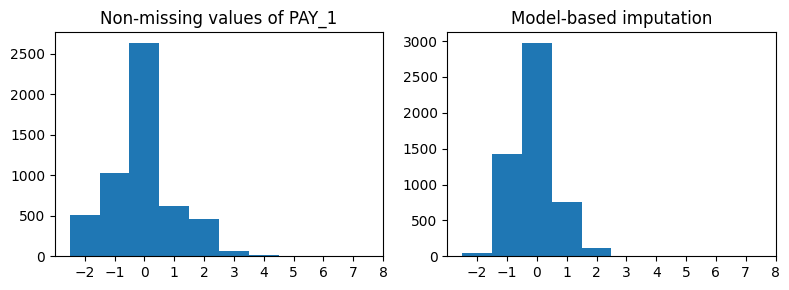

In [46]:
fig, axs = plt.subplots(1,2, figsize=(8,3))
axs[0].hist(y_impute_test, bins=bin_edges, align='left')
axs[0].set_xticks(bin_edges)
axs[0].set_title('Non-missing values of PAY_1')
axs[1].hist(y_impute_predict, bins=bin_edges, align='left')
axs[1].set_xticks(bin_edges)
axs[1].set_title('Model-based imputation')
plt.tight_layout()

A figura mostra que o modelo de imputação tem mais probabilidade de prever um valor 0 para `PAY_1` do que deveria. No entanto, ele prevê outros valores e consequentemente é mais preciso que a imputação pela moda.

Nosso modelo de imputação foi testado e os hiperparâmetros selecionados estão confirmados. Após o conjunto reservado para teste ter sido usado na verificação do desempenho do modelo com dados desconhecidos, os dados de treinamento e teste devem ser reunicos para treinarmos um modelo com o máximo de daods possível. Normalmente o aumento dos dados de treinamento resulta em um modelo melhor.

##### 12. Colete todos os valores com `PAY_1` conhecido para treinar a versão final do modelo de imputação:

In [47]:
X_impute_all = pay_1_df[features_for_imputation].values
y_impute_all = pay_1_df['PAY_1'].values

##### 13. Defina um modelo de floresta aleatória com os hiperparâmetros ótimos para imputação:

In [48]:
rf_impute = RandomForestClassifier(n_estimators=200, max_depth=12)

##### 14. Ajuste o modelo de imputação com todos os dados disponíveis:

In [49]:
rf_impute.fit(X_impute_all, y_impute_all)

RandomForestClassifier(max_depth=12, n_estimators=200)

Esse modelo esta pronto para ser usado para a imputação.

---

### Usando o modelo de imputação e comparando-o com outros métodos


Faça uma cópia do DataFrame comos valores faltantes de `PAY_1` e examine os primeiros valores

In [50]:
df_fill_pay_1_model = df_missing_pay_1.copy()
df_fill_pay_1_model['PAY_1'].head()

17    Not available
28    Not available
29    Not available
54    Not available
60    Not available
Name: PAY_1, dtype: object

Agora, substitua os valores faltantes pelas previsões do modelo de imputação e verifique novamente os valores:

In [51]:
df_fill_pay_1_model['PAY_1'] = rf_impute.predict(df_fill_pay_1_model[features_for_imputation].values)
df_fill_pay_1_model['PAY_1'].head()

17    0
28   -1
29    0
54    0
60    0
Name: PAY_1, dtype: int64

Isso mostra que os valores foram imputados como desejados. Podemos fazer uma rápida verificação das previsões usando o método *value_counts*:

In [52]:
df_fill_pay_1_model['PAY_1'].value_counts().sort_index()

PAY_1
-2      33
-1     765
 0    1718
 1     440
 2      55
 3       7
 4       1
 6       1
 8       1
Name: count, dtype: int64

Podemos  ver que há um intervalo de valores de previsão de `PAY_01` fornecidos pelo modelo de imputação que estão aproximadamente dentro da frequência relativa esperada. Temos de pegar uma amostra de 80% deles para combinar com os dados de treinamento do modelo do estudo de caso e examinar como esse método de imputação afeta o desempenho do modelo.

Divida os dados imputados por modelo e combine-os com os dados conhecidos de `PAY_1` como antes:

In [53]:
X_fill_pay_1_train, X_fill_pay_1_test, y_fill_pay_1_train, y_fill_pay_1_test = train_test_split(df_fill_pay_1_model[features_response[:-1]].values, df_fill_pay_1_model['default payment next month'].values, test_size=0.2, random_state=24)

X_train_all = np.concatenate((X_train, X_fill_pay_1_train), axis=0)
y_train_all = np.concatenate((y_train, y_fill_pay_1_train), axis=0)

Confirme se o objeto rf ainda contém o modelo com hiperparâmetros ótimos para o problema de estudo de caso

In [54]:
rf

RandomForestClassifier(max_depth=9, n_estimators=200, random_state=4, verbose=1)

Use esse modelo com a combinação de dados de treinamento imputados e não faltantes na validação cruzada como fizemos com outros métodos de imputação para testar a imputação baseada em modelo:

In [55]:
imputation_compare_cv = cross_validate(rf, X_train_all, y_train_all, scoring='roc_auc', cv=k_folds, n_jobs=-1, verbose=1, return_train_score=True, return_estimator=True, error_score='raise')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.9s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    2.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    2.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    2.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    7.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    7.3s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    7.3s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Do

Examine a pontuação média de teste do modelo entre os quatro folds:

In [56]:
np.mean(imputation_compare_cv['test_score'])

0.77290542354899

> Por escolha do livro, iremos usar o método mais simples que é a imputação baseado por moda.

Primeiro, reatribua os valores preenchidos usando a imputação com a moda igual a 0:

In [57]:
df_fill_pay_1_model['PAY_1'] = np.zeros_like(df_fill_pay_1_model['PAY_1'].values)
df_fill_pay_1_model['PAY_1'].unique()

array([0])

Agora repetiremos a divisão dos dados amputados

In [58]:
X_fill_pay_1_train, X_fill_pay_1_test, y_fill_pay_1_train, y_fill_pay_1_test = train_test_split(df_fill_pay_1_model[features_response[:-1]].values, df_fill_pay_1_model['default payment next month'].values, test_size=0.2, random_state=24)

X_train_all = np.concatenate((X_train, X_fill_pay_1_train), axis=0)
y_train_all = np.concatenate((y_train, y_fill_pay_1_train), axis=0)

E os combinaremos com  os dados não faltantes, dessa vez incluindo o conjunto de teste desconhecido que usaremos em breve:

In [59]:
X_train_all = np.concatenate((X_train, X_fill_pay_1_train), axis=0)
X_test_all = np.concatenate((X_test, X_fill_pay_1_test), axis=0)
y_train_all = np.concatenate((y_train, y_fill_pay_1_train), axis=0)
y_test_all = np.concatenate((y_test, y_fill_pay_1_test), axis=0)

Apenas para confirmar se os dados foram restaurados para o estado em que se encontravam quando testamos a imputação baseada na moda anteriormente, executaremos a validação cruzada e veremos se obtivemos a mesma pontuação:

In [60]:
imputation_compare_cv = cross_validate(rf, X_train_all, y_train_all, scoring='roc_auc', cv=k_folds, n_jobs=-1, verbose=1, return_train_score=True, return_estimator=True, error_score='raise')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    2.2s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    2.3s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    2.4s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    2.5s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    7.5s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    7.8s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    8.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    8.2s
[Parallel(n_jobs=1)]: Do

In [61]:
np.mean(imputation_compare_cv['test_score'])

0.772866246168149

Concluímos a seleção da estratégia de imputação

---

### Confirmando o desempenho do modelo com o conjunto de teste desconhecido

Agora que combinamos todos os dados não imputados e imputados para treinamento e teste, podemos treinar o modelo final desta forma:

In [62]:
rf.fit(X_train_all, y_train_all)

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    2.2s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    8.8s


RandomForestClassifier(max_depth=9, n_estimators=200, random_state=4, verbose=1)

Faremos previsões de não pagamento de dívidas com o conjunto de teste. Temos de prever probabilidades para poder calcular a ROC AUC:

In [63]:
y_test_all_predict_proba = rf.predict_proba(X_test_all)

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s


Importe a função *roc_auc* e calcule a pontuação de teste:

In [64]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_test_all, y_test_all_predict_proba[:,1])

0.7696243835824927

Podemos ver que a pontuação de teste aqui, 0.770, esta aproximadamente dentro do desvio padrão igual a 1 da estimativa da validação cruzada. Concluímos que o modelo é robusto e está pronto para distribuição para o cliente.

---

### Exercício 25: Caracterizando custos e economias

A conexão entre a saída do modelo e as decisões empresariais que o cliente tomará se resume à seleção de um limite para a probabilidade prevista do modelo. Portanto, neste exercício, caracterizaremos os custos esperados do programa de aconselhamento, em termos do custo da oferta de sessões individuais de aconselhamento, assim como a economia esperada, em relação a evitar inadimplências, em um intervalo de limites. Haverá um custo e uma economia diferentes em cada limite, porque esperamos que cada limite resulte em um número diferente de previsões positivas e em um número diferente de verdadeiros positivos dentro dessas previsões. A primeira etapa é criar um array de possíveis limites. usaremos 0 a 1, crscendo em incrementos de 0,01. Execute as etapas a seguir para fazer o exercício.

##### 1. Crie um intervalo de limites para calcular os custos e benefícios esperados do aconselhamento com este código:

In [65]:
thresholds = np.linspace(0, 1, 101)

Ele cria 101 pontos linearmente espaçados entre 0 e 1, inclusive.

Precisamos saber a possível economia alcançada com a não inadimplência. Para calculá-la, teríamos de conhecer a fatura do próximo mês. No entanto, o cliente nos informou que ela não estará disponível na hora da criação da lista de titulares de conta a serem procurados. Logo, para estimar a possível economia, usaremos o valor médio da fatura mensal mais recente de todas as contas para representar a economia de evitarmos a inadimplência para cada conta.

Algumas contas terão valores de fatura mensal maiores e outras terão valores menores. Se houver um relacionamento importante entre o valor da fatura e a probabilidade de inadimplência, usar um valor de fatura médio para calcular a economia para todas as contas pode não produzir resultados precisos. Nesse caso um exercício de modelagem preditiva pode ser tentado para estimar a fatura do próximo mês para cada conta e assim teremos um palpite mais preciso da possível economia por conta. Porém, os valores das faturas não estavam entre as cinco características mais importantes do modelo de floresta aleatória, então, a associação com a probabilidade de inadimplência não é tão forte como com as outras características. Consequentemente, essa suposição simplificadora não deve afetar tanto os resultados.

Usaremos os dados de teste para criar essa análise, já que ela fornece uma simução de como o modelo será empregado após ser distribuído para o cliente: com novas contas que não foram usadas no treinamento do modelo.

##### 2. Confirme o índice do array de características de dados de teste que corresponde à fatura do mês mais recente:

In [66]:
df[features_response[:-1]].columns[5]

'BILL_AMT1'

Essa é a fatura do mês mais recente.

##### 3. Capture o valor de fatura médio como a possível economia por inadimplência e observe-o:

In [67]:
savings_per_default = np.mean(X_test_all[:, 5])
savings_per_default

51601.7433479286

A média da fatura do mês mais recente entre as contas é de NT$51,602. Logo, usando a suposição de que essa é a oportunidade de economia da não inadimplência para cada conta, a economia líquida após um custo de NT$7,500 para aconselhamento de crédito será de NT$44,102. Isso indica um potencial de economia líquida no programa de aconselhamento de crédito.

O problema é que nem todas as contas ficarão inadimplentes. Para uma conta que não inadimpliria, uma sessão de aconselhamento representa a perda de NT$7,500. Nossa análise precisa balancear os custos de aconselhamento com o risco de inadimplência.

##### 4. Armazene o custo de aconselhamento em uma variável para usar na análise:

In [68]:
cost_per_counseling = 7500

Também sabemos conforme informações do cliente que o programa de aconselhamento não é 100% eficaz. Devemos levar isso em consideração na nossa análise.

##### 5. Armazene a taxa de eficácia que o cliente forneceu para usarmos na análise:

In [69]:
effectiveness = 0.7

Agora, calcularemos os custos e a economia para cada um dos limites. Percorreremos cada cálculo e o explicaremos, mas, por enquanto temos de criar arrays vazios para conter os resultados de cada limite.

##### 6. Crie arrays vazios para armazenar os resultados da análise. Explicaremos o que cada um conterá nas próximas etapas:

In [70]:
n_pos_pred = np.empty_like(thresholds)
cost_of_all_counselings = np.empty_like(thresholds)
n_true_pos = np.empty_like(thresholds)
savings_of_all_counselings = np.empty_like(thresholds)
savings_based_on_balances = np.empty_like(thresholds)

Essas linhas criam arrays vazios com um número de elementos igual ao dos limites de nosso análise. Percorreremos o valor de cada limite para preencher esses arrays.

##### Loop for das etapas 7 a 14:

7. Crie uma variável de contador e abra um loop *for* para percorrer os limites:

Para cada limite haverá um número diferente de previsões prositivas, de acordo com quantas probabilidades previstas estiverem acima desse limite. Elas correspondem às contas que têm previsão de inadimplir. Cada conta que tem previsão de inadimplir receberá um telefonema do aconselhamento que tem um custo associado. Essa é a primeira parte do calculo.

8. Determine que contas têm previsões positivas neste limite:

*pos_pred* é um array booleano. A soma de *pos_pred* indica o número de inadimplências previstas nesse limite.

9. Calcule o número de previsões positivas neste limite:

10. Calcule o custo de aconselhamento total neste limite:

Agora que caracterizamos os possíveis custos do programa de aconselhamento em cada limite, temos de ver qual é a economia possível. A economia ocorre quando o aconselhamento é oferecido para os titulares de contas certos: os que caso contrário, ficariam inadimplentes. No caso do problema de classificação, estamos falando das previsões positivas, em que o valor real da varável de resposta também é positivo. Em outras palavaras, são os verdadeiros positivos.

11. Determine que contas são verdadeiros positivos, de acordo com o array de previsões positivas e a variável de resposta:

12. Calcule o número de verdadeiros positivos como a soma do array de verdadeiros positivos:

A economia que podemos obter aconselhando com sucesso titulares de contas que, caso contrário, ficariam inadimplentes depende da economia ao evitarmos cada inadimplência, assim como da taxa de eficácia do aconselhamento. Não podemos impedir todas as inadimplências.

13. Calcule a economia antecipada nesse limite usando o número de verdadeiros positivos, a economia por inadimplência evitada e a taxa de eficácia do aconselhamento:

14. Incremente o contador:

In [84]:
# Etapa 7
counter = 0
for threshold in thresholds:
    
    # Etapa 8
    pos_pred = y_test_all_predict_proba[:,1]>threshold

    # Etapa 9
    n_pos_pred[counter] = sum(pos_pred)

    # Etapa 10
    cost_of_all_counselings[counter] = n_pos_pred[counter] * cost_per_counseling

    # Etapa 11
    true_pos = pos_pred & y_test_all.astype(bool)

    # Etapa 12
    n_true_pos[counter] = sum(true_pos)

    # Etapa 13
    savings_of_all_counselings[counter] = n_true_pos[counter] * savings_per_default * effectiveness

    # Etapa 14
    counter += 1

Depois, a economia líquida de cada limite pode ser calculada como a economia menos o custo.

##### 15. Calcule a economia líquida para todos os limites diminuindo o array de custos do array de economia:

In [85]:
net_savings = savings_of_all_counselings - cost_of_all_counselings

Agora estamos prontos para visualizar quanto podemos ajudar nosso cliente a economizar ao fornecer aconselhamento para os titulares de contas apropriados. Então, vejamos.

##### 16. Plote a economia líquida em relação aos limites:

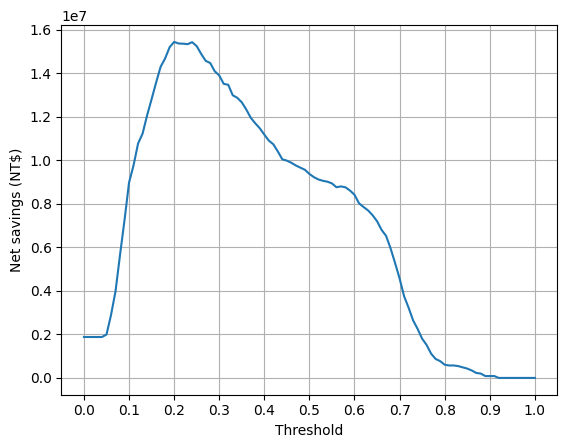

In [86]:
plt.plot(thresholds, net_savings)
plt.xlabel('Threshold')
plt.ylabel('Net savings (NT$)')
plt.xticks(np.linspace(0,1,11))
plt.grid(True)

A plotagem indica que a escolha do limite é importante. Embora seja possível gerar economia líquida para muitos valores de limite diferentes, parece que a economia líquida mais alta é ferada pela definição do limite em algum ponto do intervalo aproximado de 0.2 a 0.25

Confirmaremos o limite ótimo para a geração da maior economia e veremos quanto economizaremos.

##### 17. Encontre o índice do maior elemento do array de economias líquidas usando a função *argmax* do *NumPy*:

In [87]:
max_savings_ix = np.argmax(net_savings)

##### 18. Exiba o limite que resulta na maior economia líquida:

In [88]:
thresholds[max_savings_ix]

0.2

##### 19. Exiba a maior economia líquida possível:

In [89]:
net_savings[max_savings_ix]

15446325.35991916

Podemos ver que a maior economia líquida ocorre em um limite de 0.2 de probabilidade prevista de inadimplência. O valor da economia líquida obtida nesse limite é de mais de NT$15 milhões para o dataset de teste das contas. Essa economia teria de ser dimensionada pelo número de contas servidas pelo cliente para estimarmos a economia total possível, supondo que os dados com os quais estamos trabalhando sejam representativos de todas essas contas.

Observe no entanto que a economia é quase a mesma até um limite de cerca de 0.25, como vista no gráfico da etapa 16.

À medida que o limite aumenta, estamos "ficando mais alertas" para o nível de risco que o cliente pode apresentar, para entrarmos em contato com eles e oferecer aconselhamento. Aumentar o limite de 0.2 para 0.25 que dizer que só entraremos em contato com clientes de maior risco cuja probabilidade seja > 0.25. Isso significa contatar menos clientes, reduzindo o custo direto do programa. O grafico indica que podemos gerar o mesmo volume de economia líquida entrando em contato com menos pessoas. Embora o efeito liquido seja o mesmo, o gasto inicial com aconselhamento será menor. Isso pode ser desejável para o cliente. Examinaremos melhor esse conceito na próxima atividade.

---

### Atividade 6: Derivando insights financeiros

Os materiais brutos da análise financeira foram concluídos. Porém, podemos gerar alguns insights adicionais a partir desses resultados a fim de fornecer para o cliente mais contexto sobre como o modelo preditivo que construímos pode gerar valor para ele. Especificamente, examinamos os resultados para o conjunto de teste que reservamos na construção do modelo. O cliente pode ter mais contas além das fornecidas como representativas de seu negócio. Devemos relatar para ele resultados que possam ser facilmente dimensionados para qualquer que seja o tamanho de sua empresa, em termos de número de contas.

Também podemos ajudá-lo a saber quanto esse programa custará; embora a economia líquida seja um número importante a ser considerado, o cliente terá de prober fundos para o prorgrama de aconselhamento antes de qualquer economia ser gerada. Para finalizar, ligaremos a análise financeira às métricas padrão de desempenho dos modelos de machine learning.

Quando você termirminar a atividade, deve poder informar o custo inicial do programa de aconselhamento para o cliente, assim como obter plotagens de precisão e recall. Essa curva será útil na interpretação do valor criado pelo modelo em diferentes limites.

Execute as etapas a seguir para concluir a atividade:

##### 1. Usando o conjunto de teste, calcule o custo de todas as inadimplências se não houvesse programa de aconselhamento

In [90]:
cost_of_defaults = sum(y_test_all) * savings_per_default
cost_of_defaults

66308240.202088244

##### 2. Calcule em que percentual o custo de inadimplencias seria diminuído pelo programa de aconselhamento.

In [93]:
print(f'O custo em inadimplências seria reduzido em {round(net_savings[max_savings_ix]/cost_of_defaults*100, 2)}%')

O custo em inadimplências seria reduzido em 23.29%


Os resultados indicam que podemos diminuir o custo de inadimplências em 23% usando um programa de aconselhamento guiado pela modelagem preditiva.

##### 3. Calcule a economia líquida por conta no limite ótimo

In [95]:
print(f'A economia líquida por conta será de NT${round(net_savings[max_savings_ix]/len(y_test_all), 2)}')

A economia líquida por conta será de NT$2601.27


Resultados como esses ajudarão o cliente a dimensionar o possível valor da economia que ele pode gerar com o programa de aconselhamento para qualquer que seja o número de contas fornecidas.

##### 4. Plote a economia líquida por conta em relação ao custo do aconselhamento por conta para cada limite.

Text(0, 0.5, 'Net savings per account (NT$)')

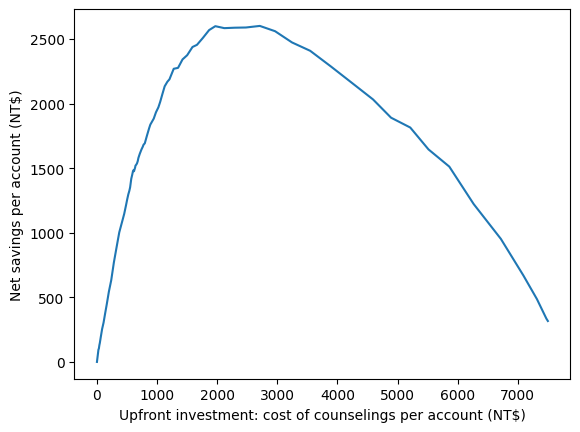

In [97]:
plt.plot(cost_of_all_counselings/len(y_test_all), net_savings/len(y_test_all))
plt.xlabel('Upfront investment: cost of counselings per account (NT$)')
plt.ylabel('Net savings per account (NT$)')

Isso indica quanto o cliente precisa orçar para o programa de aconselhamento em um mês específico para obeter a economia desejada. Parece que o maior benefício pode ser criado por um orçamento de ate NT$2000 por conta. Depois disso, a economia líquida é relativamente pouca e então declina. Talvez o cliente não consiga reservar essa quantia para o programa. Porém, esse gráfico lhe dará provas para solicitar um orçamento maior se necessário.

Esse resultado corresponde ao nosso gráfico do exercício anterior. Embora tenhamos mostrado que o limite ótimo é 0.2, pode ser bom para o cliente usar um limite mais alto de até 0.25, fazendo então menos previsões positivas, offerecendo aconselhamento para menos titulares de contas e tendo um custo dereto menor com o programa. O gráfico do exercicio anterior mostra como isso ocorre em termos de custo e economia líquida por conta.

##### 5. Plote a fração de contas previstas como positivas (isso se chama "flag rate") em cada limite:

Text(0, 0.5, 'Flag rate')

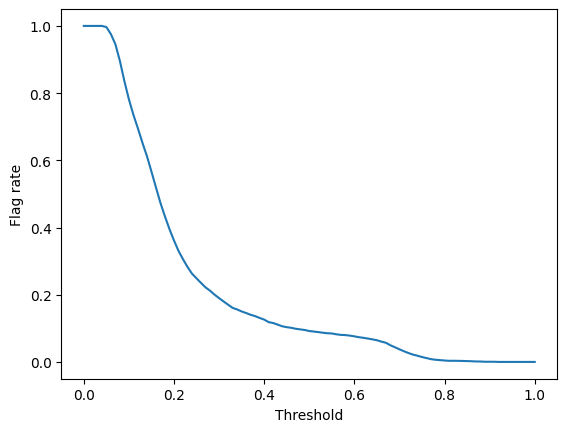

In [100]:
plt.plot(thresholds, n_pos_pred/len(y_test_all))
plt.xlabel('Threshold')
plt.ylabel('Flag rate')

Essa plotagem mostra a fração de pessoas previstas como inadimplentes e, portanto, para as quais é recomendada assistência em cada limite. Parece que, em um limite ótimo de 0.2, só cerca de 30% das contas serão marcadas para aconselhamento. Isso mostra como usar um modelo para priorizar contas para aconselhamento pode ajudar a encontrar as contas certas e reduzir o desperdício de recursos. Limites mais altos, que podem resultar em uma economia quase ótima até um limite de cerca de 0.25 como mostrada na figura do Exercício 25, resultam em flag rates mais baixas

##### 6. Plote uma curva precision-recall para os dados de teste:

/tmp/ipykernel_8469/671886296.py:1: RuntimeWarning: invalid value encountered in divide
  plt.plot(n_true_pos/sum(y_test_all), np.divide(n_true_pos, n_pos_pred))


Text(0, 0.5, 'Precision')

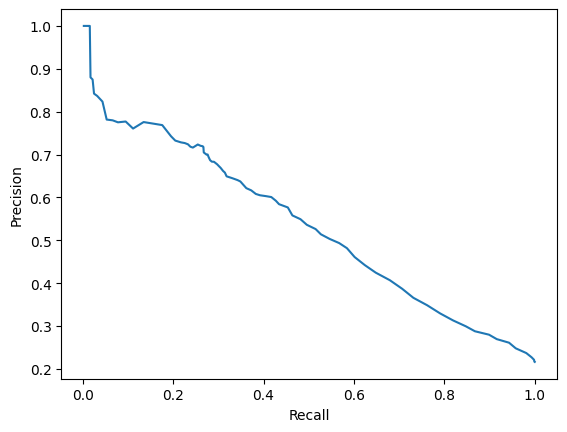

In [101]:
plt.plot(n_true_pos/sum(y_test_all), np.divide(n_true_pos, n_pos_pred))
plt.xlabel('Recall')
plt.ylabel('Precision')

A figura mostra que, para começar a obter uma taxa de verdadeiros positivos (isto é, recall) muito acima de 0, temos de aceitar uma precisão perto de 0.75 ou mais baixa. Logo, parece que há espaço para melhoria em nosso modelo. Embora isso não precise ser informado ao cliente, mostra que com o uso de técnicas de modelagem mais avançadas, ou um conjunto de características mais rico, o desempenho do modelo pode ser melhorado.

A precisão e o recall têm uma ligação direta com o custo e a economia do programa: quanto mais precisas forem suas previsões, menos dinheiro você perderá em aconselhamento devido a previsões incorretas. E, quanto mais alto o recall, mais economia poderemos gerar identificando com sucesso contas que ficariam inadimplentes. Compare o código dessa etapa com o usado para caluclar o custo e a economia no exercício anterior para ver. Isso liga a análise financeira às métricas de machine learning que examinamos no início do estudo de caso.

Para ver a conexão da precisão e do recall com o limite usado para definir previsões positivas e negativas, pode ser instrutivo plotá-los separadamente.

##### 7. Plote a precisão e o recall separadamente no eixo y em relação ao limite no eixo x

/tmp/ipykernel_8469/2887908393.py:1: RuntimeWarning: invalid value encountered in divide
  plt.plot(thresholds, np.divide(n_true_pos, n_pos_pred), label='Precision')


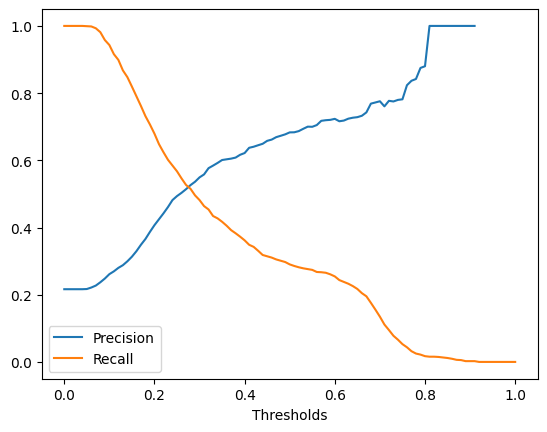

In [102]:
plt.plot(thresholds, np.divide(n_true_pos, n_pos_pred), label='Precision')
plt.plot(thresholds, n_true_pos/sum(y_test_all), label= 'Recall')
plt.xlabel('Thresholds')
plt.legend()


Essa plotagem explica por que o limite ótimo é 0.2. Embora o limite ótimo também dependa da análise financeira de custos e economia, podemos ver aqui que a parte mais íngreme do aumento inicial na precisão , que representa a exatidão das previsões positivas e, portanto, é uma medida de como o aconselhamento guiado porr modelo pode ser eficaz, coorre até um limite de cerca de 0.2.